# Dataset preparation

In total, we are going to use 40 000 images. We’ll put 32 000 of them into the training set, and the rest 8 000 we’ll use for the validation. To split the data, run the code below:

In [1]:
# from split_data.py
import argparse
import csv
import os

import numpy as np
from PIL import Image
from tqdm import tqdm


def save_csv(data, path, fieldnames=['image_path', 'gender', 'articleType', 'baseColour']):
    with open(path, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for row in data:
            writer.writerow(dict(zip(fieldnames, row)))


def split_data():
    input_folder = "data/myntradataset"
    output_folder = "data/myntradataset"
    annotation = os.path.join(input_folder, 'styles.csv')

    # open annotation file
    all_data = []
    with open(annotation) as csv_file:
        # parse it as CSV
        reader = csv.DictReader(csv_file)
        # tqdm shows pretty progress bar
        # each row in the CSV file corresponds to the image
        for row in tqdm(reader, total=reader.line_num):
            # we need image ID to build the path to the image file
            img_id = row['id']
            # we're going to use only 3 attributes
            gender = row['gender']
            articleType = row['articleType']
            baseColour = row['baseColour']
            img_name = os.path.join(input_folder, 'images', str(img_id) + '.jpg')
            # check if file is in place
            if os.path.exists(img_name):
                # check if the image has 80*60 pixels with 3 channels
                img = Image.open(img_name)
                if img.size == (60, 80) and img.mode == "RGB":
                    all_data.append([img_name, gender, articleType, baseColour])

    # set the seed of the random numbers generator, so we can reproduce the results later
    np.random.seed(42)
    # construct a Numpy array from the list
    all_data = np.asarray(all_data)
    # Take 40000 samples in random order
    inds = np.random.choice(40000, 40000, replace=False)
    # split the data into train/val and save them as csv files
    save_csv(all_data[inds][:32000], os.path.join(output_folder, 'train.csv'))
    save_csv(all_data[inds][32000:40000], os.path.join(output_folder, 'val.csv'))

split_data()

44446it [00:03, 13449.85it/s]


# Working with the dataset from code

As we have more than one label in our data annotation, we need to tweak the way we read the data and load it in the memory. To do that, we’ll create a class that inherits PyTorch Dataset. It will be able to parse our data annotation and extract only the labels of our interest. The key difference between the multi-output and single-class classification is that we will return several labels per each sample from the dataset.

In [2]:
# from dataset.py

import csv

import numpy as np
from PIL import Image
from torch.utils.data import Dataset

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class AttributesDataset():
    def __init__(self, annotation_path):
        color_labels = []
        gender_labels = []
        article_labels = []

        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                color_labels.append(row['baseColour'])
                gender_labels.append(row['gender'])
                article_labels.append(row['articleType'])

        self.color_labels = np.unique(color_labels)
        self.gender_labels = np.unique(gender_labels)
        self.article_labels = np.unique(article_labels)

        self.num_colors = len(self.color_labels)
        self.num_genders = len(self.gender_labels)
        self.num_articles = len(self.article_labels)

        self.color_id_to_name = dict(zip(range(len(self.color_labels)), self.color_labels))
        self.color_name_to_id = dict(zip(self.color_labels, range(len(self.color_labels))))

        self.gender_id_to_name = dict(zip(range(len(self.gender_labels)), self.gender_labels))
        self.gender_name_to_id = dict(zip(self.gender_labels, range(len(self.gender_labels))))

        self.article_id_to_name = dict(zip(range(len(self.article_labels)), self.article_labels))
        self.article_name_to_id = dict(zip(self.article_labels, range(len(self.article_labels))))


class FashionDataset(Dataset):
    def __init__(self, annotation_path, attributes, transform=None):
        super().__init__()

        self.transform = transform
        self.attr = attributes

        # initialize the arrays to store the ground truth labels and paths to the images
        self.data = []
        self.color_labels = []
        self.gender_labels = []
        self.article_labels = []

        # read the annotations from the CSV file
        with open(annotation_path) as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.data.append(row['image_path'])
                self.color_labels.append(self.attr.color_name_to_id[row['baseColour']])
                self.gender_labels.append(self.attr.gender_name_to_id[row['gender']])
                self.article_labels.append(self.attr.article_name_to_id[row['articleType']])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # take the data sample by its index
        img_path = self.data[idx]

        # read image
        img = Image.open(img_path)

        # apply the image augmentations if needed
        if self.transform:
            img = self.transform(img)

        # return the image and all the associated labels
        dict_data = {
            'img': img,
            'labels': {
                'color_labels': self.color_labels[idx],
                'gender_labels': self.gender_labels[idx],
                'article_labels': self.article_labels[idx]
            }
        }
        return dict_data

# Model description

Have a look into the model class definition. We take mobilenet_v2 network from torchvision.models. This model can solve the ImageNet classification, so its last layer is a single classifier.

To use this model for our multi-output task, we will modify it. We need to predict three properties, so we’ll use three new classification heads instead of a single classifier: these heads are called color, gender and article. Each head will have its own cross-entropy loss

In [3]:
# from model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class MultiOutputModel(nn.Module):
    def __init__(self, n_color_classes, n_gender_classes, n_article_classes):
        super().__init__()
        self.base_model = models.mobilenet_v2().features  # take the model without classifier
        last_channel = models.mobilenet_v2().last_channel  # size of the layer before classifier

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        self.color = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_color_classes)
        )
        self.gender = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_gender_classes)
        )
        self.article = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_article_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return {
            'color': self.color(x),
            'gender': self.gender(x),
            'article': self.article(x)
        }

    def get_loss(self, net_output, ground_truth):
        color_loss = F.cross_entropy(net_output['color'], ground_truth['color_labels'])
        gender_loss = F.cross_entropy(net_output['gender'], ground_truth['gender_labels'])
        article_loss = F.cross_entropy(net_output['article'], ground_truth['article_labels'])
        loss = color_loss + gender_loss + article_loss
        return loss, {'color': color_loss, 'gender': gender_loss, 'article': article_loss}

# Training

Let's define helper function to calculate the metrics of our model during training / testing.

In [4]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def calculate_metrics(output, target):
    _, predicted_color = output['color'].cpu().max(1)
    gt_color = target['color_labels'].cpu()

    _, predicted_gender = output['gender'].cpu().max(1)
    gt_gender = target['gender_labels'].cpu()

    _, predicted_article = output['article'].cpu().max(1)
    gt_article = target['article_labels'].cpu()

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_color = accuracy_score(y_true=gt_color.numpy(), y_pred=predicted_color.numpy())
        accuracy_gender = accuracy_score(y_true=gt_gender.numpy(), y_pred=predicted_gender.numpy())
        accuracy_article = accuracy_score(y_true=gt_article.numpy(), y_pred=predicted_article.numpy())

    return accuracy_color, accuracy_gender, accuracy_article

Let's define helper function to show image grid with labels. It helps understand our data better

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize_gt_data(dataset, attributes):
    imgs = []
    gt_labels = []

    n_cols = 5
    n_rows = 3

    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for img_idx in range(n_cols * n_rows):
        sample = dataset[img_idx]
        img = sample['img']
        labels = sample['labels']
        gt_color = attributes.color_id_to_name[labels['color_labels']]
        gt_gender = attributes.gender_id_to_name[labels['gender_labels']]
        gt_article = attributes.article_id_to_name[labels['article_labels']]
        
        imgs.append(img)
        gt_labels.append("{}\n{}\n{}".format(gt_gender, gt_article, gt_color))

    title = "Ground truth labels"

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, gt_labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # restore original transforms
    dataset.transform = transforms

To estimate the accuracy of the model during training we will need the validation procedure

In [6]:
def checkpoint_load(model, name):
    print('Restoring checkpoint: {}'.format(name))
    model.load_state_dict(torch.load(name, map_location='cpu'))
    epoch = int(os.path.splitext(os.path.basename(name))[0].split('-')[1])
    return epoch


def net_output_to_predictions(output):
    _, predicted_colors = output['color'].cpu().max(1)
    _, predicted_genders = output['gender'].cpu().max(1)
    _, predicted_articles = output['article'].cpu().max(1)

    return predicted_colors.numpy().tolist(), predicted_genders.numpy().tolist(), predicted_articles.numpy().tolist()


def validate(model, dataloader, device, logger=None, epoch=None, checkpoint=None):
    if checkpoint is not None:
        checkpoint_load(model, checkpoint)

    model.eval()
    color_predictions = []
    gender_predictions = []
    article_predictions = []
    with torch.no_grad():
        avg_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in dataloader:
            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            val_train, val_train_losses = model.get_loss(output, target_labels)
            avg_loss += val_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            (batch_color_predictions,
             batch_gender_predictions,
             batch_article_predictions) = net_output_to_predictions(output)

            color_predictions.extend(batch_color_predictions)
            gender_predictions.extend(batch_gender_predictions)
            article_predictions.extend(batch_article_predictions)

    n_samples = len(dataloader)
    avg_loss /= n_samples
    accuracy_color /= n_samples
    accuracy_gender /= n_samples
    accuracy_article /= n_samples
    print('-' * 72)
    print("Validation  loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}\n".format(
        avg_loss, accuracy_color, accuracy_gender, accuracy_article))

    if logger is not None and epoch is not None:
        logger.add_scalar("val_loss", avg_loss, epoch)
        logger.add_scalar("val_accuracy/color", accuracy_color, epoch)
        logger.add_scalar("val_accuracy/gender", accuracy_gender, epoch)
        logger.add_scalar("val_accuracy/article", accuracy_article, epoch)
    model.train()

    return color_predictions, gender_predictions, article_predictions

Now, we're ready to define the training procedure:

In [7]:
# from train.py

import argparse
import os
from datetime import datetime

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    


def train(start_epoch=1, N_epochs=50, batch_size=16, num_workers=8):
    attributes_file = 'data/myntradataset/styles.csv'
    device = torch.device('cuda')

    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # specify image transforms for augmentation during training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                shear=None, resample=False, fillcolor=(255, 255, 255)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    
    train_dataset = FashionDataset('data/myntradataset/train.csv', attributes, train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = FashionDataset('data/myntradataset/val.csv', attributes, val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = MultiOutputModel(n_color_classes=attributes.num_colors,
                             n_gender_classes=attributes.num_genders,
                             n_article_classes=attributes.num_articles)\
                            .to(device)

    optimizer = torch.optim.Adam(model.parameters())

    savedir = os.path.join('checkpoints', get_cur_time())
    print(savedir)
    os.makedirs(savedir, exist_ok=False)

    n_train_samples = len(train_dataloader)

    
    visualize_gt_data(val_dataset, attributes)
    print("\nAll gender labels:\n", attributes.gender_labels)
    print("\nAll color labels:\n", attributes.color_labels)
    print("\nAll article labels:\n", attributes.article_labels)

    print("Starting training ...")

    checkpoint_path = None
    for epoch in range(start_epoch, N_epochs + 1):
        total_loss = 0
        accuracy_color = 0
        accuracy_gender = 0
        accuracy_article = 0

        for batch in train_dataloader:
            optimizer.zero_grad()

            img = batch['img']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_color, batch_accuracy_gender, batch_accuracy_article = \
                calculate_metrics(output, target_labels)

            accuracy_color += batch_accuracy_color
            accuracy_gender += batch_accuracy_gender
            accuracy_article += batch_accuracy_article

            loss_train.backward()
            optimizer.step()

        print("epoch {:4d}, loss: {:.4f}, color: {:.4f}, gender: {:.4f}, article: {:.4f}".format(
            epoch,
            total_loss / n_train_samples,
            accuracy_color / n_train_samples,
            accuracy_gender / n_train_samples,
            accuracy_article / n_train_samples))

        logger.add_scalar('train_loss', total_loss / n_train_samples, epoch)

        if epoch % 25 == 0:
            checkpoint_path = checkpoint_save(model, savedir, epoch)

        if epoch % 5 == 0:
            validate(model, val_dataloader, device, logger, epoch)
            
    checkpoint_path = checkpoint_save(model, savedir, epoch - 1)

    return checkpoint_path

/home/carter/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/carter/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/carter/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/carter/anaconda3/lib/python3.7/site-packages/tensorboar

In [8]:
# last_checkpoint_path = train()

# Evaluation

As we have trained models now, let's evaluate them at our validation set. Also we can visualize some additional information, like confusion matrics, that helps us understand our models better.

In [9]:
# from test.py

import argparse
import os


import numpy as np
import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader


def visualize_grid(dataset, attributes, color_predictions, gender_predictions, article_predictions):
    imgs = []
    labels = []
    predicted_color_all = []
    predicted_gender_all = []
    predicted_article_all = []

    gt_labels = []
    gt_color_all = []
    gt_gender_all = []
    gt_article_all = []

    
    # store the original transforms from the dataset
    transforms = dataset.transform
    # and not use them during visualization
    dataset.transform = None

    for (sample, 
         predicted_color, 
         predicted_gender, 
         predicted_article) in zip(
             dataset, color_predictions, gender_predictions, article_predictions):
        predicted_color = attributes.color_id_to_name[predicted_color]
        predicted_gender = attributes.gender_id_to_name[predicted_gender]
        predicted_article = attributes.article_id_to_name[predicted_article]

        gt_color = attributes.color_id_to_name[sample['labels']['color_labels']]
        gt_gender = attributes.gender_id_to_name[sample['labels']['gender_labels']]
        gt_article = attributes.article_id_to_name[sample['labels']['article_labels']]

        predicted_color_all.append(predicted_color)
        predicted_gender_all.append(predicted_gender)
        predicted_article_all.append(predicted_article)

        gt_color_all.append(gt_color)
        gt_gender_all.append(gt_gender)
        gt_article_all.append(gt_article)

        imgs.append(sample['img'])
        labels.append("{}\n{}\n{}".format(predicted_gender, predicted_article, predicted_color))
        gt_labels.append("{}\n{}\n{}".format(gt_gender, gt_article, gt_color))
        if len(imgs) > 400: break

    # restore original transforms
    dataset.transform = transforms

    # Draw confusion matrices
    # color
    cn_matrix = confusion_matrix(
        y_true=gt_color_all,
        y_pred=predicted_color_all,
        labels=attributes.color_labels,
        normalize='true')
    
    plt.rcParams.update({'font.size': 5})
    plt.rcParams.update({'figure.dpi': 300})
    ConfusionMatrixDisplay(cn_matrix, attributes.color_labels).plot(
        include_values=False, xticks_rotation='vertical')
    plt.title("Colors")
    plt.tight_layout()
    plt.show()

    # gender
    cn_matrix = confusion_matrix(
        y_true=gt_gender_all,
        y_pred=predicted_gender_all,
        labels=attributes.gender_labels,
        normalize='true')
    ConfusionMatrixDisplay(cn_matrix, attributes.gender_labels).plot(
        xticks_rotation='horizontal')
    plt.title("Genders")
    plt.tight_layout()
    plt.show()

    plt.rcParams.update({'font.size': 2.5})
    cn_matrix = confusion_matrix(
        y_true=gt_article_all,
        y_pred=predicted_article_all,
        labels=attributes.article_labels,
        normalize='true')
    ConfusionMatrixDisplay(cn_matrix, attributes.article_labels).plot(
        include_values=False, xticks_rotation='vertical')
    plt.title("Article types")
    plt.show()

    plt.rcParams.update({'font.size': 5})
    plt.rcParams.update({'figure.dpi': 100})
    title = "Predicted labels"
    n_cols = 5
    n_rows = 3
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10))
    axs = axs.flatten()
    for img, ax, label in zip(imgs, axs, labels):
        ax.set_xlabel(label, rotation=0)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(img)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



def test(checkpoint_path):
    attributes_file = 'data/myntradataset/styles.csv'

    device = torch.device("cuda")
    # attributes variable contains labels for the categories in the dataset and mapping between string names and IDs
    attributes = AttributesDataset(attributes_file)

    # during validation we use only tensor and normalization transforms
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    test_dataset = FashionDataset('data/myntradataset/val.csv', attributes, val_transform)
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

    model = MultiOutputModel(n_color_classes=attributes.num_colors, n_gender_classes=attributes.num_genders,
                             n_article_classes=attributes.num_articles).to(device)

    model_predictions = validate(model, test_dataloader, device, checkpoint=checkpoint_path)

    # Visualization of the trained model
    visualize_grid(test_dataset, attributes, *model_predictions)

Restoring checkpoint: checkpoints/2020-07-01_17-05/checkpoint-000050.pth
------------------------------------------------------------------------
Validation  loss: 2.0391, color: 0.6419, gender: 0.8910, article: 0.8284



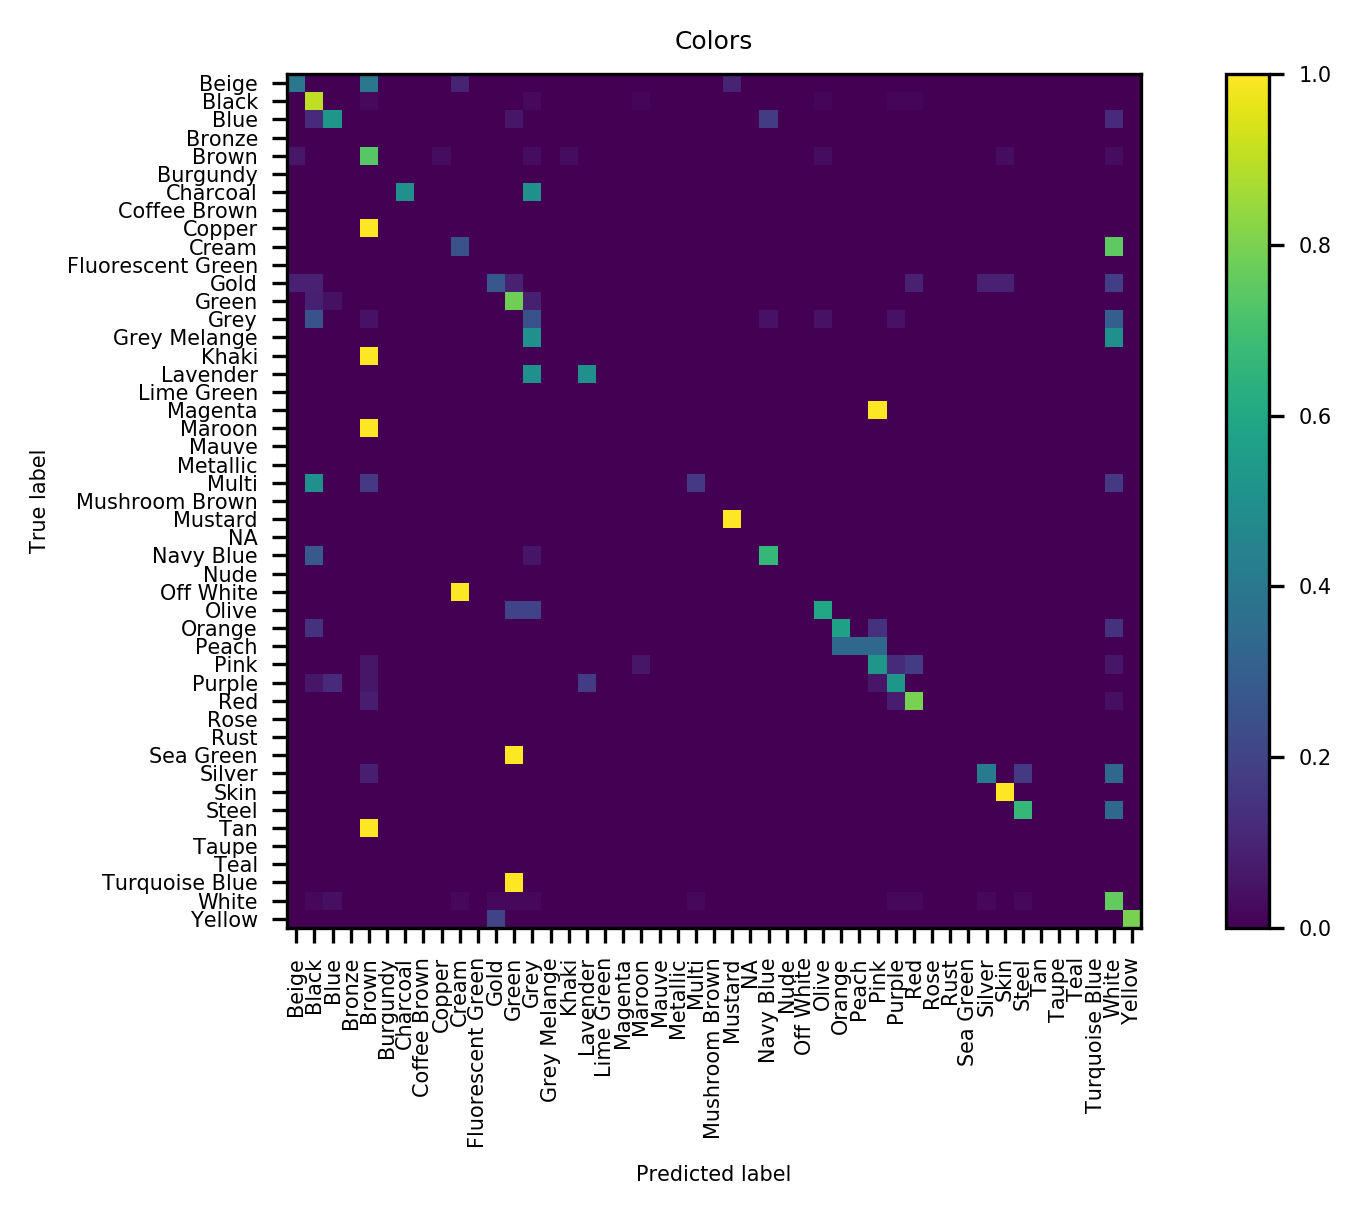

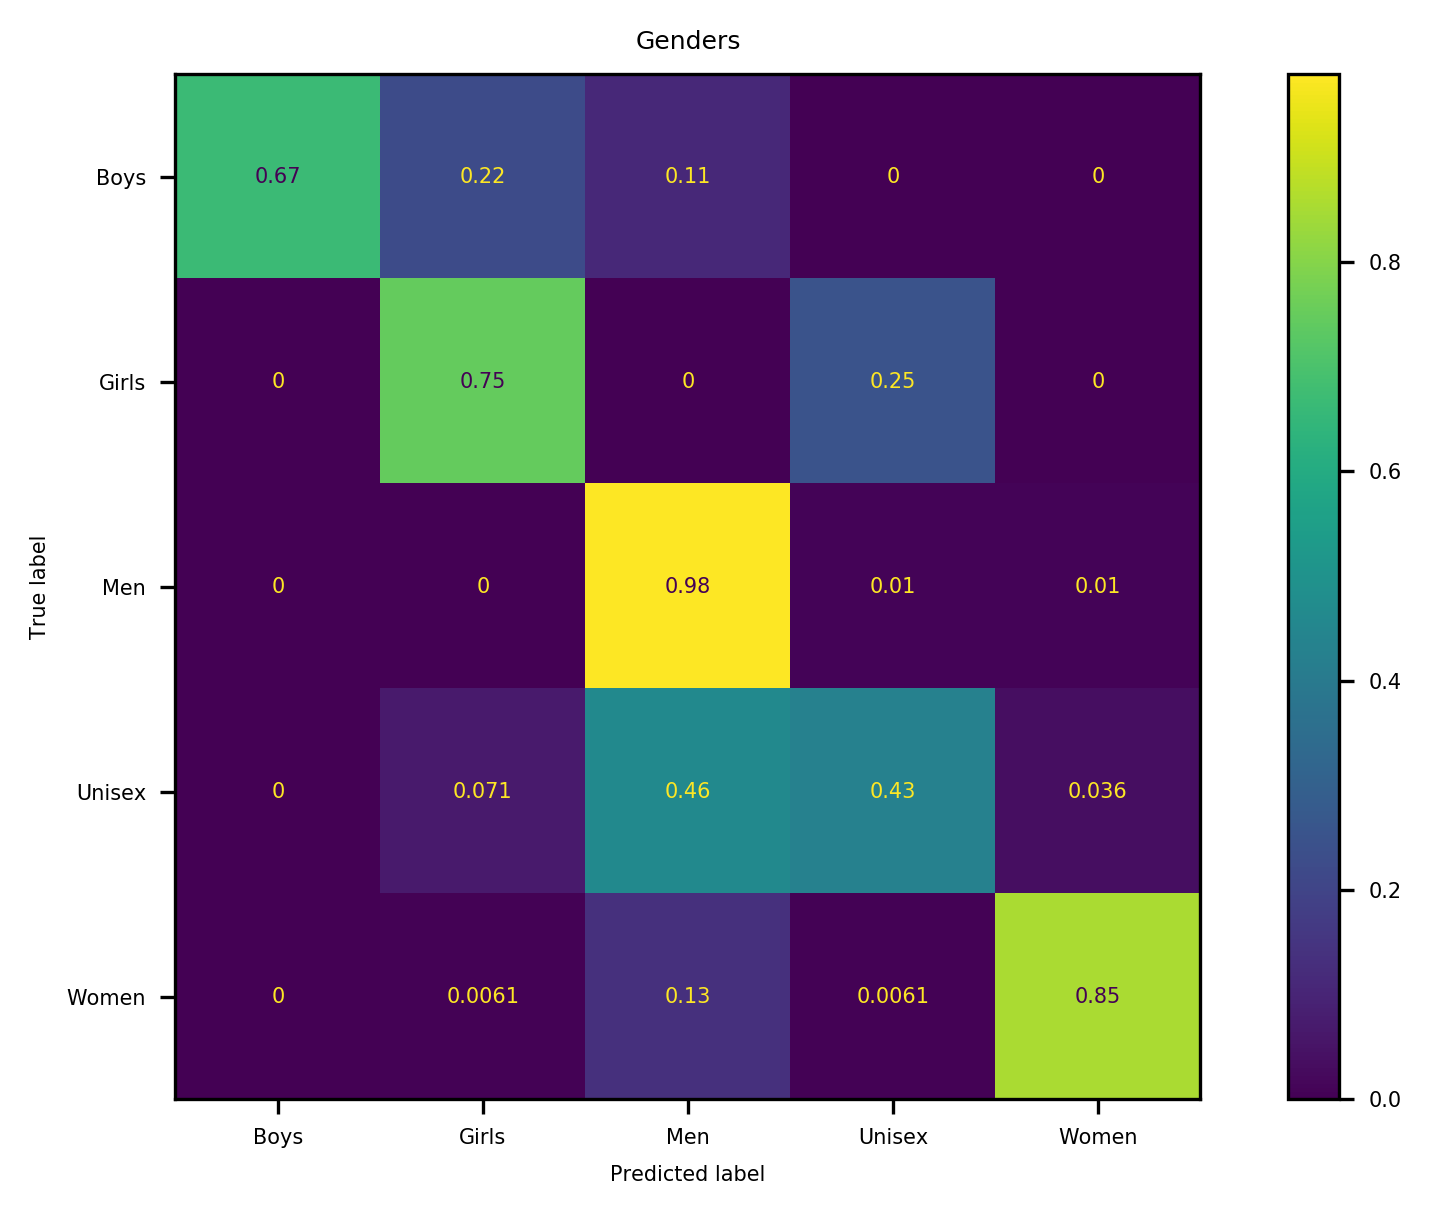

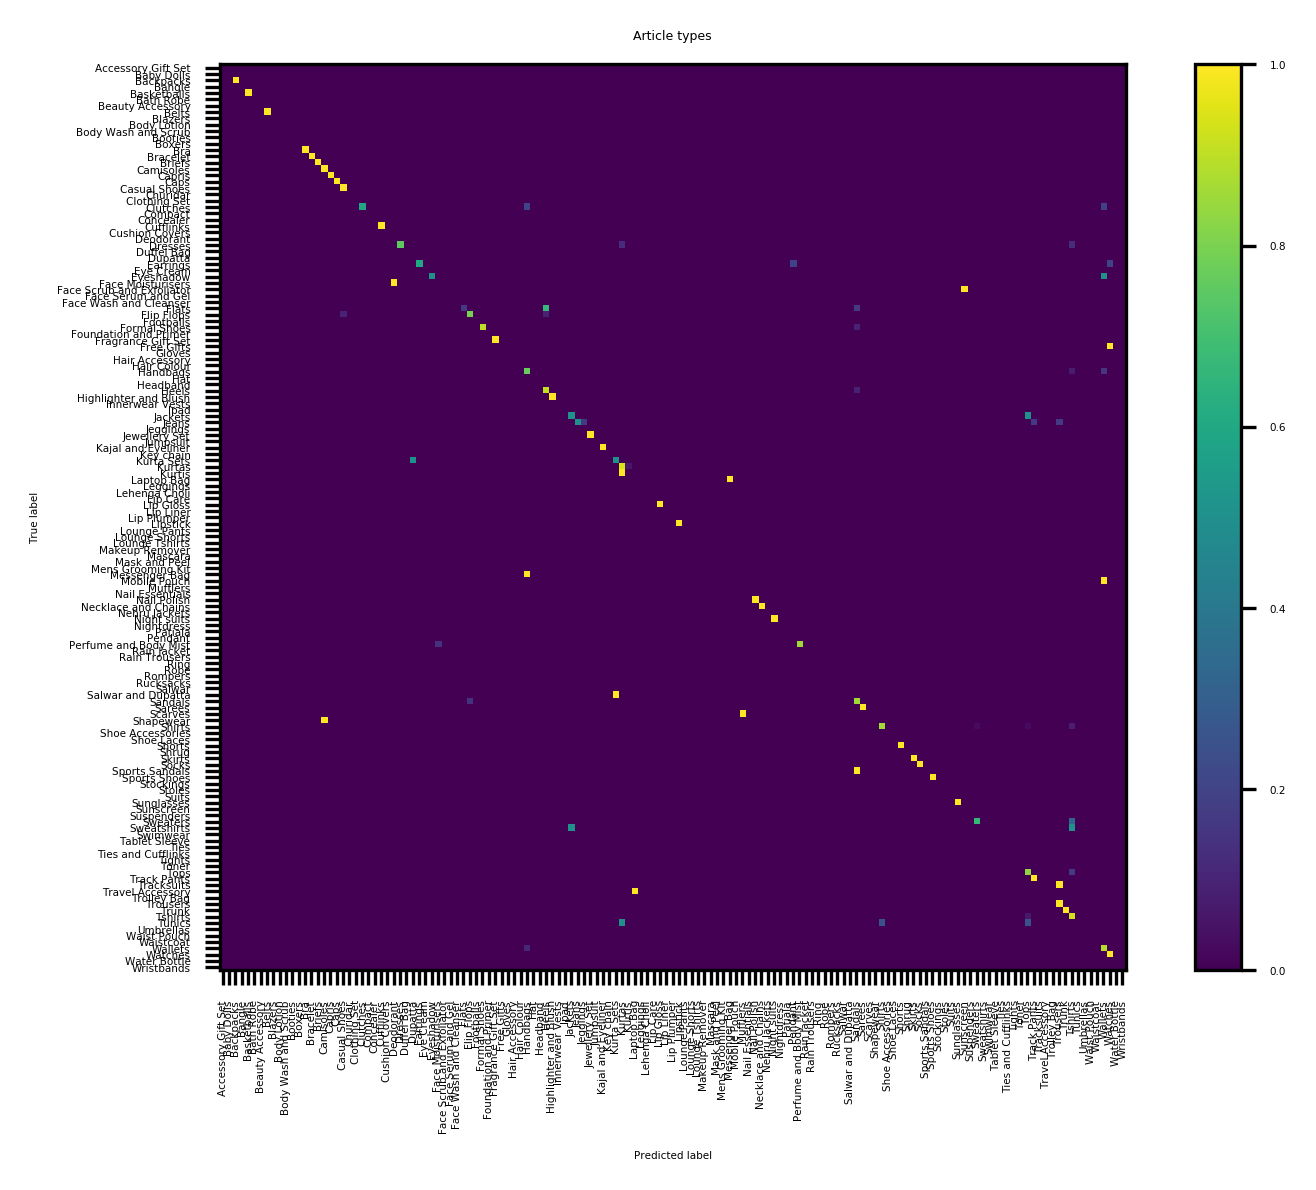

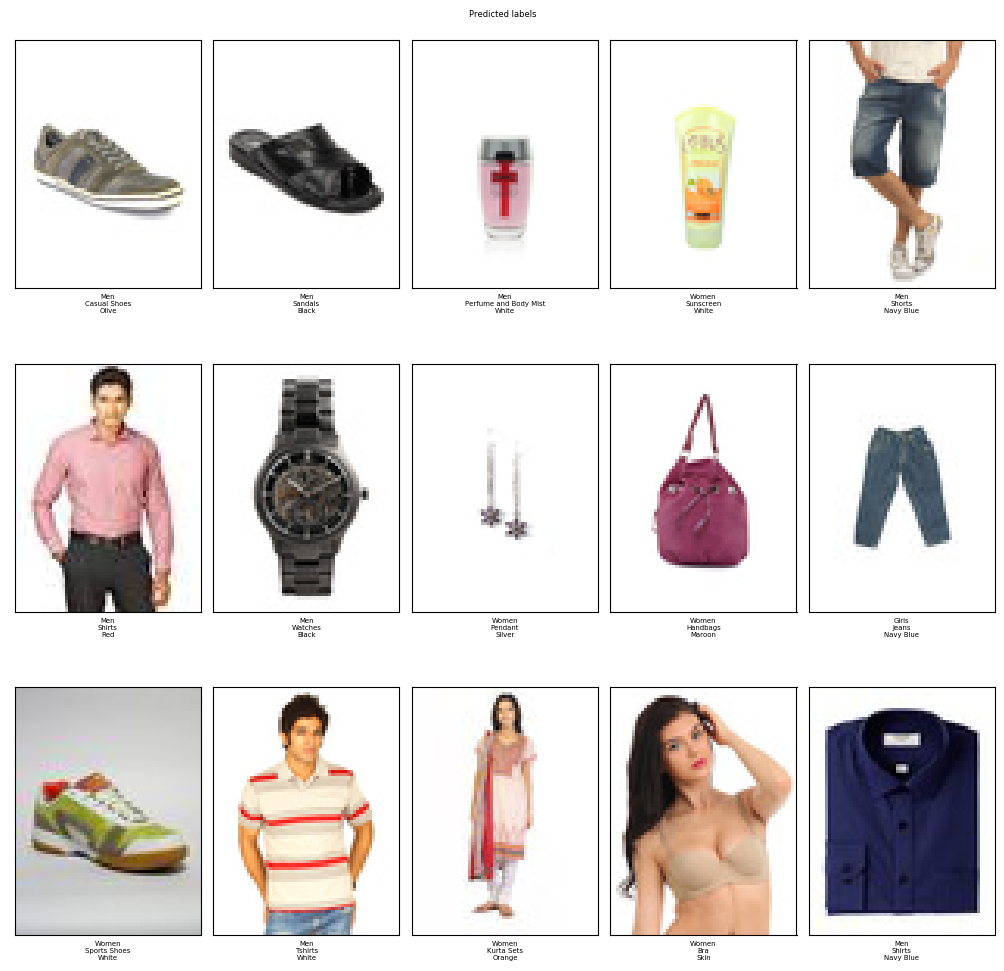

In [10]:
last_checkpoint_path = "checkpoints/2020-07-01_17-05/checkpoint-000050.pth"
test(last_checkpoint_path)